In [1]:
%pylab inline
import os
import keras
from sklearn import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

#from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from tensorflow.keras.layers import Layer, InputSpec

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
     

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
! ls -l /kaggle/input/mnistdataset

In [26]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#

import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)#shape the images into 1 dimension 
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

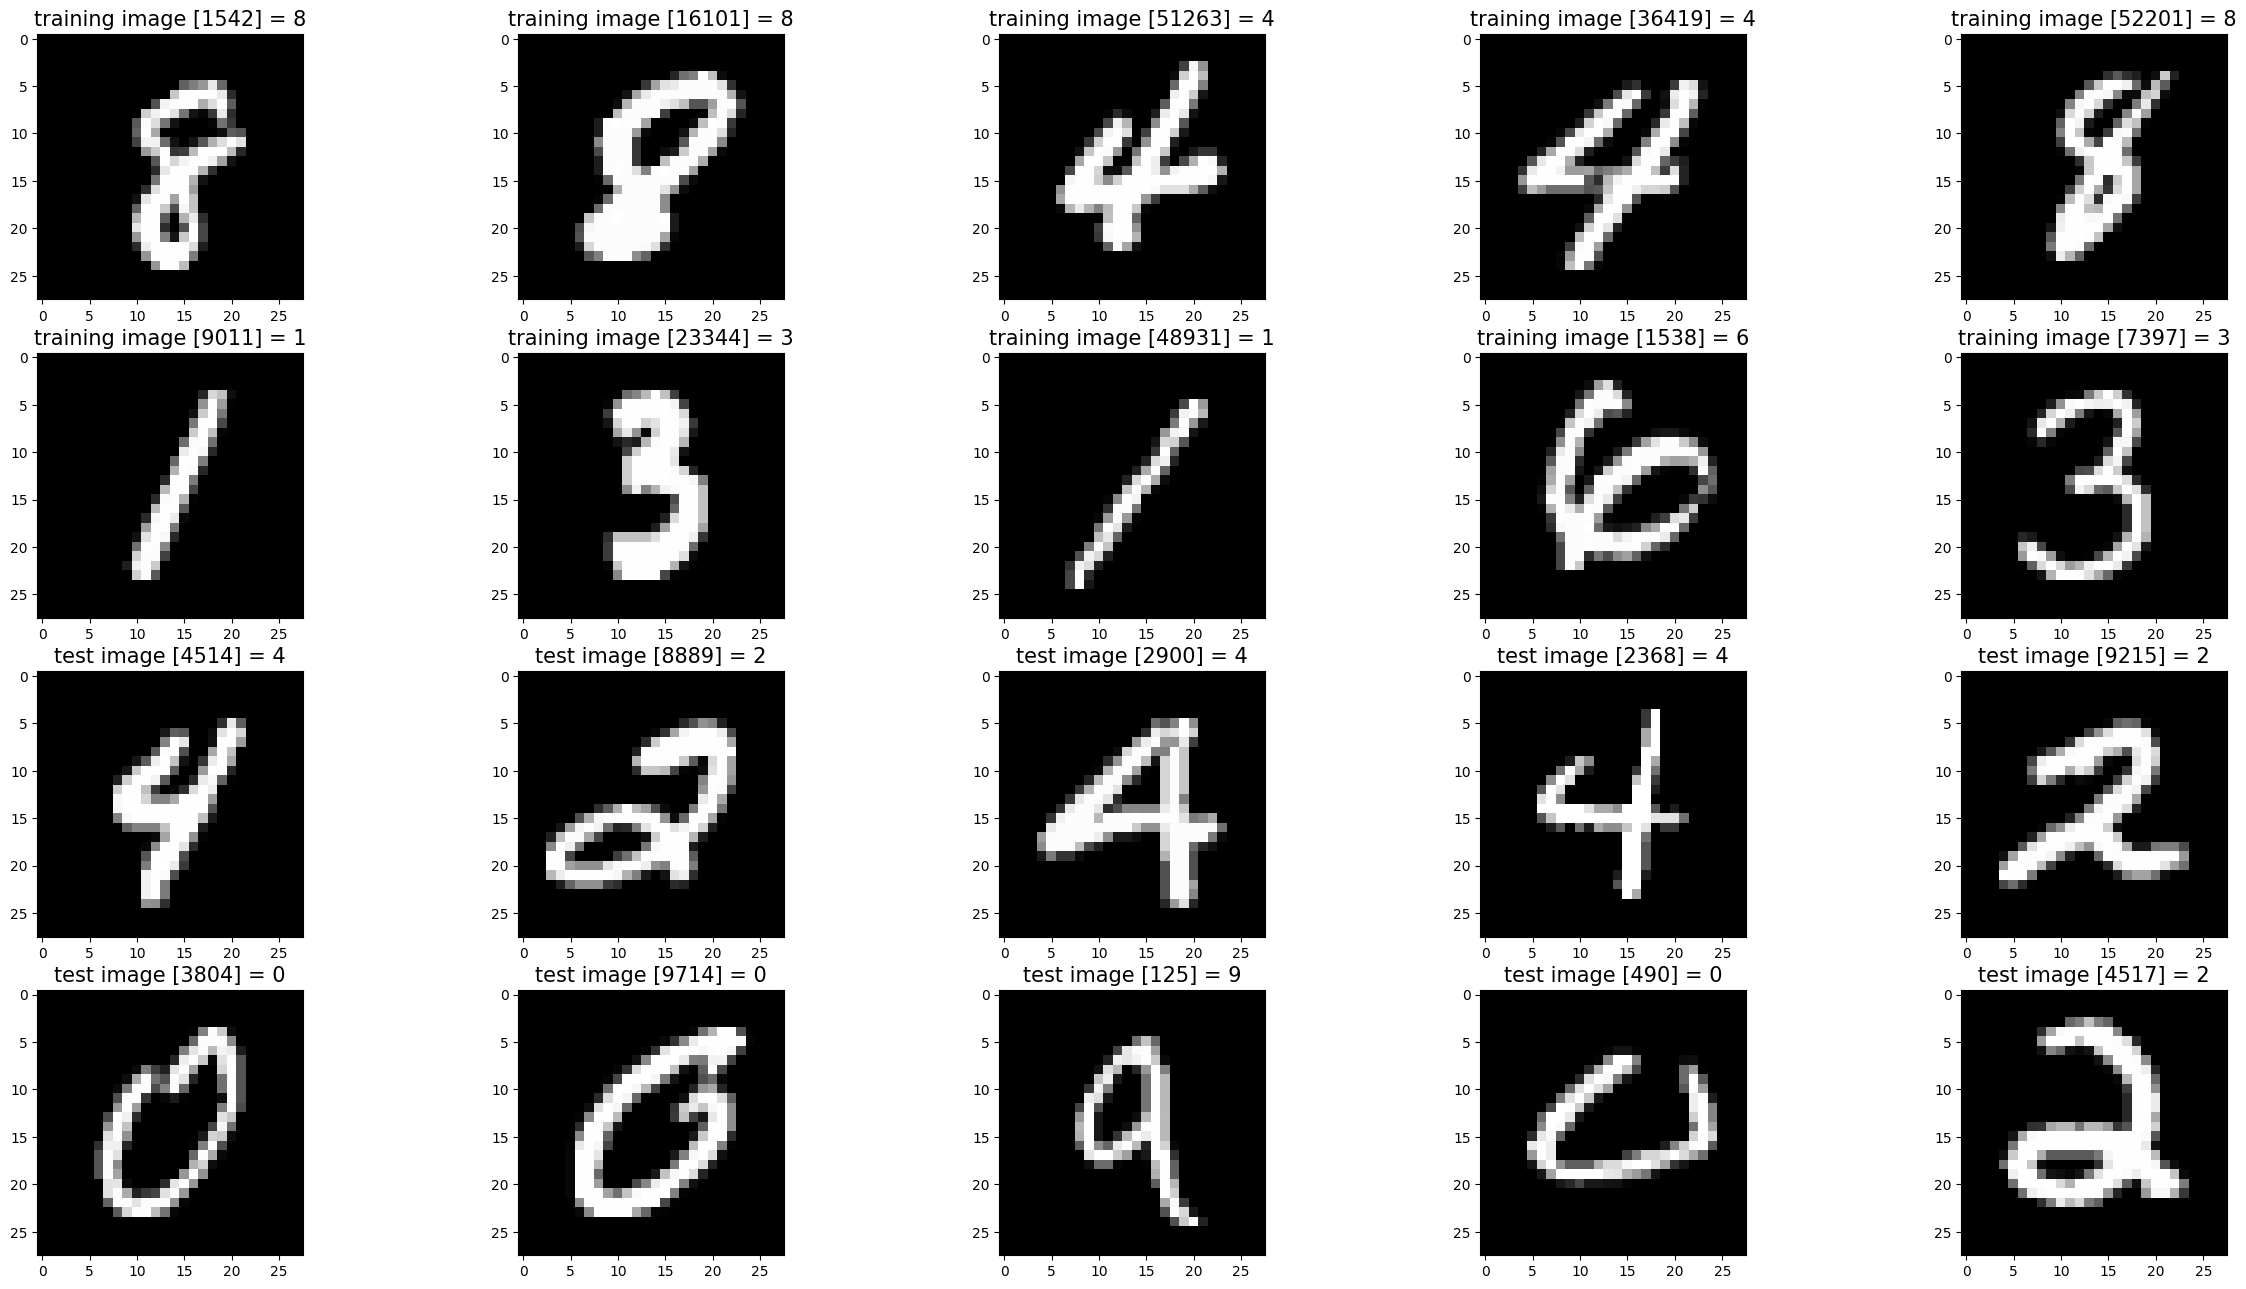

In [27]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../input/mnistdataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000) #there are 60000 images
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 10):
    r = random.randint(1, 10000)#there are 100000 images
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [54]:
type(x_train)

numpy.ndarray

In [55]:
x_train.shape

(11, 784)

In [59]:
x_test.shape

(20, 784)

In [28]:
#store the images in a numpy array to create a train  file.
x_train = np.stack(images_2_show)
#intensity of colors 0=black 255= white inbetween shades of grey
x_train = x_train/ 255.0 
x_train = x_train.reshape(-1, 784).astype('float32')



In [29]:
#store the images in a numpy array to create a  test file.
x_test = np.stack(images_2_show)
#we need to reshape the images to make sure kears can read them.
x_test = x_test/255.0 #dividing by the highest intensity to scale into 0-1 interval
x_test = x_test.reshape(-1, 784).astype('float32')
#y_train = titles_2_show.label.values


In [30]:
y_train = np.stack(titles_2_show)


 ##### divide our training data into train and validation set.

In [42]:
split_size = int(x_train.shape[0]*0.7)

x_train, val_x = x_train[:split_size], x_train[split_size:]
y_train, val_y = y_train[:split_size], y_train[split_size:]

##### first apply K-Means directly to our image and divide it into 10 clusters.

In [43]:
km = KMeans( n_clusters=10, n_init=20)
km.fit(x_train)

KMeans(n_clusters=10, n_init=20)

##### Now that we have trained our model, let’s see how it performs on the validation set.

In [44]:
pred = km.predict(val_x)
print(pred)

[2 6 2 8 2]


##### We will use Normalized Mutual Information (NMI) score to evaluate our model

In [45]:
normalized_mutual_info_score(val_y, pred)

0.7424834172925047

 #### first use an autoencoder to decrease the dimensionality of the data and extract useful information. This will then pass on the information to the K-Means algorithm.

In [46]:
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_16 (Dense)            (None, 500)               392500    
                                                                 
 dense_17 (Dense)            (None, 500)               250500    
                                                                 
 dense_18 (Dense)            (None, 2000)              1002000   
                                                                 
 dense_19 (Dense)            (None, 10)                20010     
                                                                 
 dense_20 (Dense)            (None, 2000)              22000     
                                                                 
 dense_21 (Dense)            (None, 500)               1000

### applying adam optimizer and mean square error as a loss function

In [47]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

#### Now let us train our autoencoder model. choosing 500 epochs, batch size is 2048.

In [48]:
train_history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=2048, validation_data=(val_x, val_x))

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.1119 - val_loss: 0.1147
Epoch 2/500
1/1 [==============================] - 0s 63ms/step - loss: 0.1069 - val_loss: 0.1083
Epoch 3/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0996 - val_loss: 0.0986
Epoch 4/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0882 - val_loss: 0.0905
Epoch 5/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0771 - val_loss: 0.0908
Epoch 6/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0730 - val_loss: 0.0829
Epoch 7/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0628 - val_loss: 0.0789
Epoch 8/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0580 - val_loss: 0.0786
Epoch 9/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0562 - val_loss: 0.0800
Epoch 10/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0545 - val_loss: 0.0837
Epoch 11/500
1/1 [===

In [38]:
pred_auto_train = encoder.predict(x_train)
pred_auto = encoder.predict(val_x)

1/1 [==============================] - 0s 29ms/step


In [39]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [41]:
normalized_mutual_info_score(val_y, pred)

0.8571428571428571

#### We see that our combined Autoencoder and K-Means model performs better than an individual K-Means model.